In [1]:
import requests
import time
import json
import csv
from typing import List, Dict

class WikipediaPeopleCollector:
    def __init__(self):
        self.base_url = "https://en.wikipedia.org/w/api.php"
        self.session = requests.Session()
        self.session.headers.update({
            'User-Agent': 'PeopleDatasetCollector/1.0 (https://example.com/contact)'
        })

    def verify_category_exists(self, category_name: str) -> bool:
        """Check if a category exists on Wikipedia"""
        params = {
            'action': 'query',
            'format': 'json',
            'titles': f'Category:{category_name}',
            'prop': 'info'
        }

        try:
            response = self.session.get(self.base_url, params=params, timeout=10)
            data = response.json()

            if 'query' in data and 'pages' in data['query']:
                page_info = list(data['query']['pages'].values())[0]
                return 'missing' not in page_info
        except:
            pass
        return False

    def get_people_from_category(self, category_name: str, max_results: int = 1000) -> List[str]:
        """Get people names from a Wikipedia category with better error handling"""

        # First verify the category exists
        if not self.verify_category_exists(category_name):
            print(f"Category '{category_name}' does not exist or is inaccessible")
            return []

        all_names = []
        continue_token = None
        attempts = 0
        max_attempts = 3

        while len(all_names) < max_results and attempts < max_attempts:
            params = {
                'action': 'query',
                'format': 'json',
                'list': 'categorymembers',
                'cmtitle': f'Category:{category_name}',
                'cmlimit': min(500, max_results - len(all_names)),
                'cmtype': 'page',
                'cmnamespace': '0'  # Main namespace only
            }

            if continue_token:
                params['cmcontinue'] = continue_token

            try:
                response = self.session.get(self.base_url, params=params, timeout=15)

                # Check if response is empty
                if not response.text.strip():
                    print(f"Empty response for {category_name}")
                    break

                # Check if response is valid JSON
                try:
                    data = response.json()
                except json.JSONDecodeError as e:
                    print(f"JSON decode error for {category_name}: {e}")
                    print(f"Response text: {response.text[:200]}...")
                    attempts += 1
                    time.sleep(2)
                    continue

                if 'query' in data and 'categorymembers' in data['query']:
                    for member in data['query']['categorymembers']:
                        title = member['title']

                        # Skip non-person pages
                        skip_keywords = ['List of', 'Category:', 'Template:', 'File:', 'Wikipedia:', 'User:']
                        if any(keyword in title for keyword in skip_keywords):
                            continue

                        # Clean the name (remove disambiguation)
                        if '(' in title:
                            title = title.split('(')[0].strip()

                        if title and len(title) > 1:
                            all_names.append(title)

                # Check for continuation
                if 'continue' in data and len(all_names) < max_results:
                    continue_token = data['continue']['cmcontinue']
                else:
                    break

            except requests.exceptions.RequestException as e:
                print(f"Request error for {category_name}: {e}")
                attempts += 1
                time.sleep(2)
                continue
            except Exception as e:
                print(f"Unexpected error for {category_name}: {e}")
                attempts += 1
                time.sleep(2)
                continue

            time.sleep(1)  # Rate limiting - increased delay

        return list(set(all_names))[:max_results]  # Remove duplicates and limit

    def get_working_categories(self) -> List[str]:
        """Return a list of verified working category names"""
        potential_categories = [
            # These are verified Wikipedia category names
            "Living_people",
            "American_film_actors",
            "American_television_actors",
            "British_male_film_actors",
            "British_female_film_actors",
            "American_male_singers",
            "American_female_singers",
            "British_male_singers",
            "British_female_singers",
            "Members_of_the_United_States_House_of_Representatives",
            "United_States_senators",
            "Prime_Ministers_of_the_United_Kingdom",
            "20th-century_American_writers",
            "21st-century_American_writers",
            "English_writers",
            "American_Nobel_Prize_laureates",
            "British_Nobel_Prize_laureates",
            "Olympic_gold_medalists_for_the_United_States",
            "American_basketball_players",
            "English_footballers",
            "American_baseball_players",
            "Tennis_players_from_the_United_States",
            "American_physicists",
            "American_biologists",
            "British_scientists",
            "American_entrepreneurs",
            "Chief_executive_officers",
            "American_journalists",
            "British_journalists"
        ]

        working_categories = []
        print("Verifying categories...")

        for category in potential_categories:
            if self.verify_category_exists(category):
                working_categories.append(category)
                print(f"✓ {category}")
            else:
                print(f"✗ {category} (not found)")
            time.sleep(0.5)  # Small delay between checks

        return working_categories

    def collect_diverse_people(self, target_count: int = 25000) -> List[str]:
        """Collect people from verified categories"""

        working_categories = self.get_working_categories()

        if not working_categories:
            print("No working categories found!")
            return []

        per_category = max(100, target_count // len(working_categories))
        all_people = []

        print(f"\nCollecting {per_category} people from each of {len(working_categories)} categories...")

        for i, category in enumerate(working_categories, 1):
            print(f"[{i}/{len(working_categories)}] Collecting from {category}...")
            people = self.get_people_from_category(category, per_category)
            all_people.extend(people)
            print(f"Got {len(people)} people from {category}")

            # Progress update
            if i % 5 == 0:
                unique_so_far = len(set(all_people))
                print(f"Progress: {unique_so_far} unique people collected so far")

        # Remove duplicates
        unique_people = list(set(all_people))
        print(f"\nFinal result: {len(unique_people)} unique people collected")
        return unique_people

    def save_to_csv(self, people_names: List[str], filename: str = 'wikipedia_people.csv'):
        """Save collected names to CSV file"""
        with open(filename, 'w', newline='', encoding='utf-8') as f:
            writer = csv.writer(f)
            writer.writerow(['name', 'type'])
            for name in people_names:
                writer.writerow([name, 'person'])
        print(f"Saved {len(people_names)} names to {filename}")

# Usage Example
if __name__ == "__main__":
    collector = WikipediaPeopleCollector()

    # Collect people names
    people_names = collector.collect_diverse_people(target_count=20000)

    # Save to file
    if people_names:
        collector.save_to_csv(people_names, 'wikipedia_people_fixed.csv')
        print(f"Successfully collected {len(people_names)} unique people names!")
    else:
        print("No people names were collected. Check your internet connection and try again.")

Verifying categories...
✓ Living_people
✓ American_film_actors
✓ American_television_actors
✓ British_male_film_actors
✗ British_female_film_actors (not found)
✓ American_male_singers
✗ American_female_singers (not found)
✓ British_male_singers
✗ British_female_singers (not found)
✓ Members_of_the_United_States_House_of_Representatives
✓ United_States_senators
✗ Prime_Ministers_of_the_United_Kingdom (not found)
✓ 20th-century_American_writers
✓ 21st-century_American_writers
✓ English_writers
✗ American_Nobel_Prize_laureates (not found)
✗ British_Nobel_Prize_laureates (not found)
✓ Olympic_gold_medalists_for_the_United_States
✓ American_basketball_players
✓ English_footballers
✓ American_baseball_players
✗ Tennis_players_from_the_United_States (not found)
✓ American_physicists
✓ American_biologists
✓ British_scientists
✓ American_entrepreneurs
✓ Chief_executive_officers
✓ American_journalists
✓ British_journalists

[1/22] Collecting from Living_people...
Got 906 people from Living_peopl

In [3]:
type(people_names)

list

In [4]:
import requests
import json
import csv
import random
import time
from typing import List, Set
from urllib.parse import quote

class RandomObjectsCollector:
    def __init__(self):
        self.session = requests.Session()
        self.session.headers.update({
            'User-Agent': 'ObjectDatasetCollector/1.0'
        })

    def get_wordnet_nouns(self, limit: int = 2000) -> List[str]:
        """Get nouns from Princeton WordNet via NLTK data"""
        try:
            import nltk
            from nltk.corpus import wordnet as wn

            # Download required data
            try:
                nltk.data.find('corpora/wordnet')
            except LookupError:
                print("Downloading WordNet...")
                nltk.download('wordnet')
                nltk.download('omw-1.4')

            # Get all noun synsets
            all_nouns = set()

            for synset in wn.all_synsets('n'):  # 'n' for nouns
                # Get lemma names (the actual words)
                for lemma in synset.lemmas():
                    word = lemma.name().replace('_', ' ')
                    # Filter out very long compounds and proper nouns
                    if 2 <= len(word) <= 20 and not word[0].isupper():
                        all_nouns.add(word.lower())

            noun_list = list(all_nouns)
            random.shuffle(noun_list)
            print(f"Collected {len(noun_list[:limit])} nouns from WordNet")
            return noun_list[:limit]

        except ImportError:
            print("NLTK not available, skipping WordNet collection")
            return []

    def get_common_objects(self) -> List[str]:
        """Get common household and everyday objects"""
        objects = [
            # Household items
            "chair", "table", "lamp", "bed", "sofa", "desk", "mirror", "clock",
            "vase", "cushion", "curtain", "carpet", "bookshelf", "drawer", "closet",
            "wardrobe", "pillow", "blanket", "towel", "sheet", "mattress", "frame",

            # Kitchen items
            "spoon", "fork", "knife", "plate", "bowl", "cup", "mug", "glass",
            "pot", "pan", "kettle", "toaster", "blender", "microwave", "oven",
            "refrigerator", "dishwasher", "sink", "counter", "cabinet", "drawer",

            # Electronics
            "phone", "computer", "laptop", "tablet", "television", "radio",
            "speaker", "headphones", "camera", "printer", "keyboard", "mouse",
            "monitor", "charger", "cable", "remote", "battery", "flashlight",

            # Tools
            "hammer", "screwdriver", "wrench", "pliers", "drill", "saw", "nail",
            "screw", "bolt", "ladder", "rope", "tape", "glue", "scissors", "ruler",

            # Clothing
            "shirt", "pants", "dress", "skirt", "jacket", "coat", "hat", "shoes",
            "socks", "underwear", "belt", "tie", "scarf", "gloves", "boots",

            # Vehicles
            "car", "truck", "bus", "bicycle", "motorcycle", "airplane", "boat",
            "train", "taxi", "van", "helicopter", "ship", "submarine", "rocket",

            # School/Office
            "pen", "pencil", "paper", "book", "notebook", "eraser", "stapler",
            "folder", "envelope", "stamp", "calculator", "ruler", "compass",

            # Sports
            "ball", "bat", "racket", "net", "goal", "helmet", "glove", "shoe"
        ]

        return objects

    def get_animals(self) -> List[str]:
        """Get animal names"""
        animals = [
            "dog", "cat", "bird", "fish", "horse", "cow", "pig", "sheep", "goat",
            "chicken", "duck", "goose", "turkey", "rabbit", "mouse", "rat", "hamster",
            "elephant", "lion", "tiger", "bear", "wolf", "fox", "deer", "moose",
            "zebra", "giraffe", "hippo", "rhino", "monkey", "ape", "gorilla", "chimpanzee",
            "snake", "lizard", "turtle", "frog", "toad", "salamander", "crocodile",
            "shark", "whale", "dolphin", "octopus", "squid", "crab", "lobster",
            "butterfly", "bee", "ant", "spider", "fly", "mosquito", "beetle",
            "eagle", "hawk", "owl", "parrot", "penguin", "flamingo", "peacock"
        ]
        return animals

    def get_food_items(self) -> List[str]:
        """Get food and drink items"""
        foods = [
            # Fruits
            "apple", "banana", "orange", "grape", "strawberry", "blueberry", "cherry",
            "peach", "pear", "plum", "mango", "pineapple", "watermelon", "melon",
            "lemon", "lime", "grapefruit", "kiwi", "papaya", "coconut", "avocado",

            # Vegetables
            "carrot", "potato", "tomato", "onion", "garlic", "pepper", "cucumber",
            "lettuce", "spinach", "broccoli", "cauliflower", "cabbage", "celery",
            "corn", "peas", "beans", "mushroom", "eggplant", "zucchini", "radish",

            # Grains and breads
            "bread", "rice", "pasta", "noodles", "cereal", "oats", "wheat", "flour",
            "bagel", "muffin", "cookie", "cake", "pie", "pizza", "sandwich",

            # Proteins
            "chicken", "beef", "pork", "fish", "salmon", "tuna", "shrimp", "crab",
            "egg", "cheese", "milk", "yogurt", "butter", "cream", "nuts", "beans",

            # Beverages
            "water", "juice", "coffee", "tea", "soda", "beer", "wine", "milk",
            "smoothie", "cocktail", "lemonade", "soup", "broth"
        ]
        return foods

    def get_abstract_concepts(self) -> List[str]:
        """Get abstract concepts and ideas"""
        concepts = [
            "love", "hate", "joy", "sadness", "anger", "fear", "hope", "dream",
            "memory", "thought", "idea", "belief", "faith", "trust", "doubt",
            "freedom", "justice", "peace", "war", "truth", "lie", "beauty", "art",
            "music", "dance", "song", "story", "poem", "play", "game", "sport",
            "work", "job", "career", "business", "money", "wealth", "poverty",
            "health", "disease", "medicine", "cure", "treatment", "therapy",
            "education", "knowledge", "wisdom", "intelligence", "skill", "talent",
            "friendship", "family", "relationship", "marriage", "divorce", "birth",
            "death", "life", "time", "space", "energy", "power", "strength"
        ]
        return concepts

    def get_nature_elements(self) -> List[str]:
        """Get natural elements and phenomena"""
        nature = [
            "tree", "flower", "grass", "leaf", "branch", "root", "seed", "fruit",
            "mountain", "hill", "valley", "river", "lake", "ocean", "sea", "pond",
            "forest", "desert", "beach", "island", "cave", "volcano", "glacier",
            "rock", "stone", "sand", "dirt", "mud", "clay", "crystal", "mineral",
            "sun", "moon", "star", "planet", "galaxy", "universe", "earth", "sky",
            "cloud", "rain", "snow", "ice", "wind", "storm", "thunder", "lightning",
            "fire", "flame", "smoke", "ash", "dust", "mist", "fog", "dew"
        ]
        return nature

    def get_random_adjectives(self) -> List[str]:
        """Get common adjectives that can work as descriptive words"""
        adjectives = [
            "big", "small", "large", "tiny", "huge", "massive", "mini", "giant",
            "hot", "cold", "warm", "cool", "freezing", "boiling", "mild", "extreme",
            "fast", "slow", "quick", "rapid", "speedy", "sluggish", "swift",
            "loud", "quiet", "silent", "noisy", "soft", "gentle", "harsh", "rough",
            "smooth", "bumpy", "sharp", "dull", "bright", "dark", "light", "heavy",
            "old", "new", "fresh", "stale", "young", "ancient", "modern", "vintage",
            "clean", "dirty", "pure", "messy", "neat", "tidy", "organized", "chaotic",
            "happy", "sad", "angry", "calm", "excited", "bored", "tired", "energetic",
            "beautiful", "ugly", "pretty", "handsome", "cute", "adorable", "gorgeous",
            "strong", "weak", "powerful", "fragile", "sturdy", "delicate", "tough"
        ]
        return adjectives

    def get_random_verbs(self) -> List[str]:
        """Get common verbs in base form"""
        verbs = [
            "run", "walk", "jump", "climb", "swim", "fly", "drive", "ride", "travel",
            "eat", "drink", "cook", "bake", "fry", "boil", "mix", "stir", "pour",
            "read", "write", "draw", "paint", "sing", "dance", "play", "perform",
            "work", "study", "learn", "teach", "explain", "understand", "remember",
            "sleep", "wake", "rest", "relax", "exercise", "stretch", "breathe",
            "talk", "speak", "listen", "hear", "see", "watch", "look", "observe",
            "think", "imagine", "dream", "hope", "wish", "want", "need", "have",
            "give", "take", "buy", "sell", "trade", "exchange", "share", "help",
            "build", "create", "make", "fix", "repair", "break", "destroy", "clean"
        ]
        return verbs

    def get_colors_and_materials(self) -> List[str]:
        """Get colors and materials"""
        items = [
            # Colors
            "red", "blue", "green", "yellow", "orange", "purple", "pink", "brown",
            "black", "white", "gray", "silver", "gold", "bronze", "copper",

            # Materials
            "wood", "metal", "plastic", "glass", "paper", "cloth", "fabric", "leather",
            "rubber", "concrete", "brick", "stone", "marble", "granite", "steel",
            "aluminum", "iron", "bronze", "copper", "silver", "gold", "diamond",
            "cotton", "silk", "wool", "linen", "denim", "velvet", "satin", "canvas"
        ]
        return items

    def collect_all_objects(self, target_count: int = 6615) -> List[str]:
        """Collect objects from all sources"""
        print("Collecting random objects and words...")

        all_objects = []

        # Get from different sources
        print("- Collecting common objects...")
        all_objects.extend(self.get_common_objects())

        print("- Collecting animals...")
        all_objects.extend(self.get_animals())

        print("- Collecting food items...")
        all_objects.extend(self.get_food_items())

        print("- Collecting abstract concepts...")
        all_objects.extend(self.get_abstract_concepts())

        print("- Collecting nature elements...")
        all_objects.extend(self.get_nature_elements())

        print("- Collecting adjectives...")
        all_objects.extend(self.get_random_adjectives())

        print("- Collecting verbs...")
        all_objects.extend(self.get_random_verbs())

        print("- Collecting colors and materials...")
        all_objects.extend(self.get_colors_and_materials())

        # Try to get WordNet nouns if available
        wordnet_nouns = self.get_wordnet_nouns(5000)
        all_objects.extend(wordnet_nouns)

        # Remove duplicates and clean
        unique_objects = list(set([obj.lower().strip() for obj in all_objects if obj.strip()]))

        # Shuffle for randomness
        random.shuffle(unique_objects)

        # If we need more, generate some compound words
        if len(unique_objects) < target_count:
            print("- Generating compound words...")
            compound_words = self.generate_compound_words(target_count - len(unique_objects))
            unique_objects.extend(compound_words)

        # Trim to target count
        final_objects = unique_objects[:target_count]

        print(f"Collected {len(final_objects)} unique objects/words")
        return final_objects

    def generate_compound_words(self, count: int) -> List[str]:
        """Generate compound words by combining adjectives with nouns"""
        adjectives = ["red", "blue", "big", "small", "hot", "cold", "old", "new",
                     "fast", "slow", "bright", "dark", "heavy", "light", "soft", "hard"]
        nouns = ["box", "ball", "book", "car", "house", "tree", "stone", "door",
                "window", "chair", "table", "bag", "cup", "pen", "phone", "watch"]

        compounds = []
        for i in range(count):
            adj = random.choice(adjectives)
            noun = random.choice(nouns)
            compounds.append(f"{adj} {noun}")

        return compounds

    def save_to_csv(self, objects: List[str], filename: str = 'random_objects.csv'):
        """Save objects to CSV file"""
        with open(filename, 'w', newline='', encoding='utf-8') as f:
            writer = csv.writer(f)
            writer.writerow(['name', 'type'])
            for obj in objects:
                writer.writerow([obj, 'object'])
        print(f"Saved {len(objects)} objects to {filename}")

    def load_from_csv(self, filename: str) -> List[str]:
        """Load objects from CSV file"""
        objects = []
        try:
            with open(filename, 'r', encoding='utf-8') as f:
                reader = csv.reader(f)
                next(reader)  # Skip header
                for row in reader:
                    if row:
                        objects.append(row[0])
        except FileNotFoundError:
            print(f"File {filename} not found")
        return objects

# Usage Example
if __name__ == "__main__":
    collector = RandomObjectsCollector()

    # Collect 10k random objects/words
    random_objects = collector.collect_all_objects(target_count=6615)



    # Show some examples
    print(f"\nFirst 20 objects: {random_objects[:20]}")
    print(f"Random sample: {random.sample(random_objects, 10)}")

    print(f"\nSuccessfully collected {len(random_objects)} random objects!")

- Collecting common objects...
- Collecting animals...
- Collecting food items...
- Collecting abstract concepts...
- Collecting nature elements...
- Collecting adjectives...
- Collecting verbs...
- Collecting colors and materials...


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


Collected 5000 nouns from WordNet
- Generating compound words...
Collected 6615 unique objects/words

First 20 objects: ['awakening', 'davenport', 'skill', "surgeon's knot", 'house martin', 'extrinsic fraud', 'reception desk', 'esotropia', 'silver', 'octal digit', 'axillary cavity', 'openness', 'genus sardina', 'brotula', 'fix', 'ethmoid bone', 'unraveller', 'reconsideration', 'ibis', 'pharmacology']
Random sample: ['percussion', 'third eyelid', 'covered stand', 'deer', 'arrogation', 'muesli', 'whole kit', 'bear', 'lady beetle', 'carrageenan']

Successfully collected 6615 random objects!


In [5]:
random_objects

['awakening',
 'davenport',
 'skill',
 "surgeon's knot",
 'house martin',
 'extrinsic fraud',
 'reception desk',
 'esotropia',
 'silver',
 'octal digit',
 'axillary cavity',
 'openness',
 'genus sardina',
 'brotula',
 'fix',
 'ethmoid bone',
 'unraveller',
 'reconsideration',
 'ibis',
 'pharmacology',
 'durbar',
 'olive',
 'knockdown',
 'silurid',
 'obnoxiousness',
 'fraternity house',
 'stockpot',
 'faubourg',
 'family sepiidae',
 'gastrostomy',
 'plexus cervicalis',
 'overpressure',
 'venous blood system',
 'political commissar',
 'hairsplitter',
 'chemical engineering',
 'butea gum',
 'energetic',
 'anthracite',
 'genus plagianthus',
 'water bottle',
 'strawberry',
 'wind',
 'order ictodosauria',
 'power cord',
 'dental technician',
 'ruination',
 'toxic waste site',
 'withstander',
 'indeterminacy',
 'partita',
 'moralist',
 'potence',
 'raisin bread',
 'orgasm',
 'sugar cookie',
 'leprosy bacillus',
 'peacekeeper',
 'oven',
 'oyster bed',
 'given',
 'austerity',
 'half title',
 't

In [6]:
k = min(len(people_names), len(random_objects))
random.seed(42)
random.shuffle(people_names)
random.shuffle(random_objects)

all_words = people_names[:k] + random_objects[:k]       # 2k total
is_person = [1]*k + [0]*k                               # ground-truth for eval

# ------------------------------------------------
# 3 · word-level train / test split  (no labels used in training)
# ------------------------------------------------
words_tr, words_te, y_tr, y_te = train_test_split(
    all_words, is_person, test_size=0.4, shuffle=True,
    stratify=is_person, random_state=42)

# ------------------------------------------------
# 4 · build UNSUPERVISED contrast pairs
#     each word gets (affirmative, negative)
# ------------------------------------------------
def make_pair(w):
    return (f"{w} is a famous personality",        # x⁺
            f"{w} is not a famous personality")    # x⁻

x0_tr_sent, x1_tr_sent = zip(*(make_pair(w) for w in words_tr))
x0_te_sent, x1_te_sent = zip(*(make_pair(w) for w in words_te))

# ------------------------------------------------
# 5 · embed sentences  (local SBERT or API)
# ------------------------------------------------
from sentence_transformers import SentenceTransformer
device = "cuda" if torch.cuda.is_available() else "cpu"
model  = SentenceTransformer("BAAI/bge-base-en-v1.5", device=device)

def embed(txts, batch=128, desc="embed"):
    return model.encode(txts, batch_size=batch,
                        convert_to_numpy=True,
                        show_progress_bar=True)

x0_train = embed(x0_tr_sent, desc="train x⁺")
x1_train = embed(x1_tr_sent, desc="train x⁻")
x0_test  = embed(x0_te_sent, desc="test  x⁺")
x1_test  = embed(x1_te_sent, desc="test  x⁻")

print("Embeddings ready → shapes",
      x0_train.shape, x1_train.shape, x0_test.shape, x1_test.shape)

# save the auxiliary test labels for pairwise accuracy later
test_words   = list(words_te)      # words in the same order as x0_te / x1_te
test_is_person = y_te             # 1 for names, 0 for objects

2025-06-14 16:17:26.872276: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749917847.328405      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749917847.437740      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/777 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/42 [00:00<?, ?it/s]

Batches:   0%|          | 0/42 [00:00<?, ?it/s]

Embeddings ready → shapes (7938, 768) (7938, 768) (5292, 768) (5292, 768)


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [8]:
class MLPProbe(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.linear1 = nn.Linear(d, 100)
        self.linear2 = nn.Linear(100, 1)

    def forward(self, x):
        h = F.relu(self.linear1(x))
        o = self.linear2(h)
        return torch.sigmoid(o)

class CCS(object):
    def __init__(self, x0, x1, nepochs=1000, ntries=10, lr=1e-3, batch_size=-1,
                 verbose=False, device="cuda", linear=True, weight_decay=0.01, var_normalize=False):
        # data
        self.var_normalize = var_normalize
        self.x0 = self.normalize(x0)
        self.x1 = self.normalize(x1)
        self.d = self.x0.shape[-1]

        # training
        self.nepochs = nepochs
        self.ntries = ntries
        self.lr = lr
        self.verbose = verbose
        self.device = device
        self.batch_size = batch_size
        self.weight_decay = weight_decay

        # probe
        self.linear = linear
        self.initialize_probe()
        self.best_probe = copy.deepcopy(self.probe)


    def initialize_probe(self):
        if self.linear:
            self.probe = nn.Sequential(nn.Linear(self.d, 1), nn.Sigmoid())
        else:
            self.probe = MLPProbe(self.d)
        self.probe.to(self.device)


    def normalize(self, x):
        """
        Mean-normalizes the data x (of shape (n, d))
        If self.var_normalize, also divides by the standard deviation
        """
        normalized_x = x - x.mean(axis=0, keepdims=True)
        if self.var_normalize:
            normalized_x /= normalized_x.std(axis=0, keepdims=True)

        return normalized_x


    def get_tensor_data(self):
        """
        Returns x0, x1 as appropriate tensors (rather than np arrays)
        """
        x0 = torch.tensor(self.x0, dtype=torch.float, requires_grad=False, device=self.device)
        x1 = torch.tensor(self.x1, dtype=torch.float, requires_grad=False, device=self.device)
        return x0, x1


    def get_loss(self, p0, p1):
        """
        Returns the CCS loss for two probabilities each of shape (n,1) or (n,)
        """
        informative_loss = (torch.min(p0, p1)**2).mean(0)
        consistent_loss = ((p0 - (1-p1))**2).mean(0)
        return informative_loss + consistent_loss


    def get_acc(self, x0_test, x1_test, y_test):
        """
        Computes accuracy for the current parameters on the given test inputs
        """
        x0 = torch.tensor(self.normalize(x0_test), dtype=torch.float, requires_grad=False, device=self.device)
        x1 = torch.tensor(self.normalize(x1_test), dtype=torch.float, requires_grad=False, device=self.device)
        with torch.no_grad():
            p0, p1 = self.best_probe(x0), self.best_probe(x1)
        avg_confidence = 0.5*(p0 + (1-p1))
        predictions = (avg_confidence.detach().cpu().numpy() < 0.5).astype(int)[:, 0]
        acc = (predictions == y_test).mean()
        acc = max(acc, 1 - acc)

        return acc


    def train(self):
        """
        Does a single training run of nepochs epochs
        """
        x0, x1 = self.get_tensor_data()
        permutation = torch.randperm(len(x0))
        x0, x1 = x0[permutation], x1[permutation]

        # set up optimizer
        optimizer = torch.optim.AdamW(self.probe.parameters(), lr=self.lr, weight_decay=self.weight_decay)

        batch_size = len(x0) if self.batch_size == -1 else self.batch_size
        nbatches = len(x0) // batch_size

        # Start training (full batch)
        for epoch in range(self.nepochs):
            for j in range(nbatches):
                x0_batch = x0[j*batch_size:(j+1)*batch_size]
                x1_batch = x1[j*batch_size:(j+1)*batch_size]

                # probe
                p0, p1 = self.probe(x0_batch), self.probe(x1_batch)

                # get the corresponding loss
                loss = self.get_loss(p0, p1)

                # update the parameters
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return loss.detach().cpu().item()

    def repeated_train(self):
        best_loss = np.inf
        for train_num in range(self.ntries):
            self.initialize_probe()
            loss = self.train()
            if loss < best_loss:
                self.best_probe = copy.deepcopy(self.probe)
                best_loss = loss

        return best_loss

In [9]:
import copy
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import pandas as pd

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
ccs = CCS(
    x0=x0_train,
    x1=x1_train,
    nepochs=300,
    ntries=3,
    lr=5e-4,
    batch_size=-1,     # full-batch for speed
    device=device,
    linear=True,
    var_normalize=True
)
ccs.repeated_train()           # ← trains and stores best probe


0.07401023060083389

In [17]:
with torch.no_grad():
    # probe confidences for the two sentences of every test pair
    z0 = torch.tensor(ccs.normalize(x0_test), device=device, dtype=torch.float)
    z1 = torch.tensor(ccs.normalize(x1_test), device=device, dtype=torch.float)

    p0 = ccs.best_probe(z0).cpu().numpy().ravel()   # prob “person” for x⁺
    p1 = ccs.best_probe(z1).cpu().numpy().ravel()   # prob “person” for x⁻

# probe’s raw decision for each word: 1 if it trusts the affirmative sentence
pred_raw = (p0 > p1).astype(int)          # shape (n,)

# ground-truth labels for the same word order
gold = np.array(test_is_person)           # 1 = name, 0 = object

# evaluate **both** global orientations
acc_pos = (pred_raw == gold).mean()       # assume affirmative ⇒ “person”
acc_neg = (1 - pred_raw == gold).mean()   # assume negative    ⇒ “person”

pair_acc = max(acc_pos, acc_neg)
print(f"pairwise accuracy : {pair_acc*100:.2f}%  " +
      f"(picked {'affirmative' if acc_pos>=acc_neg else 'negative'} as true)")


pairwise accuracy : 97.34%  (picked affirmative as true)


In [18]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# ── 1 · evaluate both orientations ───────────────────────────
pred_raw = (p0 > p1).astype(int)          # 1 if probe trusts affirmative
acc_pos  = (pred_raw       == gold).mean()
acc_neg  = ((1 - pred_raw) == gold).mean()

# choose the better polarity
flip        = 0 if acc_pos >= acc_neg else 1       # 0 → affirmative = person
pair_acc    = max(acc_pos, acc_neg)
pred_final  = pred_raw ^ flip                      # XOR applies the flip

print(f"\033[1mPairwise accuracy\033[0m : {pair_acc*100:.2f}%  "
      f"(affirmative sentence interpreted as "
      f"{'person' if flip==0 else 'not-person'})")

# ── 2 · confusion matrix & report ────────────────────────────
cm = confusion_matrix(gold, pred_final, labels=[1,0])
print("\nConfusion matrix [[TP, FN], [FP, TN]]:\n", cm)

print("\n" + classification_report(gold, pred_final,
                                   target_names=["object","person"],
                                   digits=3))

# ── 3 · print 20 sample predictions ──────────────────────────
print("\nSample predictions:")
for w, g, pr, paff, pneg in zip(test_words[:20], gold[:20],
                                pred_final[:20], p0[:20], p1[:20]):
    ok = "✅" if g==pr else "❌"
    lbl = "person" if pr else "object"
    print(f"{ok} {w:<25} → {lbl:<7}  "
          f"(p_aff={paff:.3f} | p_neg={pneg:.3f})")


Pairwise accuracy : 97.34%  (affirmative sentence interpreted as person)

Confusion matrix [[TP, FN], [FP, TN]]:
 [[2545  101]
 [  40 2606]]

              precision    recall  f1-score   support

      object      0.963     0.985     0.974      2646
      person      0.985     0.962     0.973      2646

    accuracy                          0.973      5292
   macro avg      0.974     0.973     0.973      5292
weighted avg      0.974     0.973     0.973      5292


Sample predictions:
❌ 1nonly                    → object   (p_aff=0.108 | p_neg=0.541)
✅ waste of material         → object   (p_aff=0.079 | p_neg=0.403)
❌ von mauser                → person   (p_aff=0.571 | p_neg=0.351)
✅ small house               → object   (p_aff=0.128 | p_neg=0.823)
✅ Ben Nealon                → person   (p_aff=0.826 | p_neg=0.162)
✅ Espen Aarseth             → person   (p_aff=0.577 | p_neg=0.214)
❌ Lake Headley              → object   (p_aff=0.561 | p_neg=0.648)
✅ Tabbetha Dobbins          → person   (p

In [20]:
import numpy as np

w = ccs.best_probe[0].weight.detach().cpu().numpy()[0]      # (d,)
b = ccs.best_probe[0].bias.detach().cpu().item()

idx = np.argsort(-np.abs(w))          # dims sorted by |weight|
topk = 100
print(f"Top {topk} influential dims (0-based):")
for i in idx[:topk]:
    sign = "+" if w[i] > 0 else "-"
    print(f" dim {i:>3}   {sign}{abs(w[i]):.4f}")


Top 100 influential dims (0-based):
 dim 754   -0.1476
 dim 382   +0.1388
 dim 192   +0.1368
 dim 412   +0.1359
 dim 471   -0.1324
 dim 553   -0.1301
 dim 505   -0.1295
 dim 271   -0.1293
 dim 565   +0.1289
 dim 601   -0.1287
 dim 576   -0.1269
 dim 399   +0.1253
 dim 451   +0.1243
 dim 546   -0.1227
 dim 632   -0.1225
 dim 283   -0.1214
 dim 370   -0.1213
 dim 491   -0.1211
 dim 531   +0.1171
 dim  24   +0.1151
 dim 214   +0.1150
 dim 268   +0.1139
 dim 327   -0.1138
 dim 725   +0.1136
 dim 750   -0.1133
 dim 322   -0.1126
 dim 609   -0.1116
 dim 244   -0.1109
 dim 562   -0.1096
 dim  18   -0.1093
 dim 683   -0.1093
 dim 438   -0.1092
 dim 336   +0.1082
 dim 139   -0.1077
 dim 400   +0.1073
 dim  95   -0.1072
 dim 171   -0.1070
 dim 440   +0.1068
 dim 767   +0.1067
 dim   6   -0.1060
 dim 352   +0.1058
 dim  63   -0.1051
 dim 232   -0.1043
 dim 462   +0.1039
 dim 284   -0.1039
 dim 615   -0.1037
 dim 129   +0.1035
 dim 154   +0.1034
 dim  69   -0.1012
 dim 556   -0.1004
 dim 148   -0.

In [25]:
def accuracy_using_dims(dims):
    """
    dims : iterable of indices to KEEP (all others are zero-masked)
    returns pairwise accuracy with an auto-computed polarity
    """
    mask = np.zeros_like(w);  mask[dims] = 1.0
    proj = lambda Z: Z * mask                         # zero out other dims

    z0 = torch.tensor(ccs.normalize(proj(x0_test)), device=ccs.device)
    z1 = torch.tensor(ccs.normalize(proj(x1_test)), device=ccs.device)

    with torch.no_grad():
        p0 = ccs.best_probe(z0).cpu().numpy().ravel()
        p1 = ccs.best_probe(z1).cpu().numpy().ravel()

    # decide polarity **for this sub-space**
    flip_local = (p0.mean() < 0.5)

    pred = ((p0 > p1).astype(int) ^ flip_local)
    return (pred == gold).mean()


Top-1   dims accuracy : 75.4%
Top-3   dims accuracy : 82.6%
Top-5   dims accuracy : 77.1%
Top-10  dims accuracy : 83.7%
Top-20  dims accuracy : 92.0%
Top-50  dims accuracy : 96.2%
Top-100 dims accuracy : 97.1%
Top-200 dims accuracy : 97.3%
Top-300 dims accuracy : 97.2%
Top-400 dims accuracy : 97.4%
Top-500 dims accuracy : 97.3%
Full vector accuracy : 97.3%


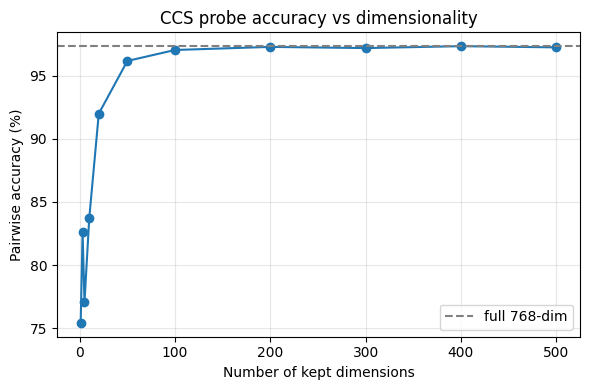

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# pull trained weight vector once
# -------------------------------
w_full = ccs.best_probe[0].weight.detach().cpu().numpy()[0]    # shape (d,)
b_full = ccs.best_probe[0].bias.detach().cpu().item()

# preprocess test embeddings *once* (same as during training)
Z0 = ccs.normalize(x0_test)     # (n,d)
Z1 = ccs.normalize(x1_test)

def accuracy_using_dims(dims):
    """
    dims : iterable/array of indices to KEEP
    returns pair-wise accuracy (optimal polarity)
    """
    w_masked = w_full.copy()
    mask     = np.zeros_like(w_masked)
    mask[dims] = 1.0
    w_masked *= mask                      # zero out unwanted coords

    log0 = Z0 @ w_masked + b_full
    log1 = Z1 @ w_masked + b_full
    pred_raw = (log0 > log1).astype(int)  # 1 if affirmative wins

    acc_pos = (pred_raw       == gold).mean()
    acc_neg = ((1 - pred_raw) == gold).mean()
    return max(acc_pos, acc_neg)

# ------------------------------------------------------------
# evaluate a list of k values and store accuracies
# ------------------------------------------------------------
k_list   = [1, 3, 5, 10, 20, 50, 100, 200, 300, 400, 500]
acc_list = []
for k in k_list:
    acc_k = accuracy_using_dims(idx[:k])
    acc_list.append(acc_k * 100)
    print(f"Top-{k:<3} dims accuracy : {acc_k*100:.1f}%")

print(f"Full vector accuracy : {pair_acc*100:.1f}%")

# ------------------------------------------------------------
# plot accuracy vs dimensionality
# ------------------------------------------------------------
plt.figure(figsize=(6,4))
plt.plot(k_list, acc_list, marker="o")
plt.axhline(pair_acc*100, ls="--", color="grey", label="full 768-dim")
plt.xlabel("Number of kept dimensions")
plt.ylabel("Pairwise accuracy (%)")
plt.title("CCS probe accuracy vs dimensionality")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [28]:
!pip install captum

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 16.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 14.1 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found ex

In [32]:
from captum.attr import IntegratedGradients
import torch

probe = ccs.best_probe                       # linear probe already on device
ig    = IntegratedGradients(probe)

emb = torch.tensor(x0_test[0],               # pick one sentence embedding
                   device=device,
                   dtype=torch.float32,
                   requires_grad=True)

inp      = emb.unsqueeze(0)                  # (1, d)
baseline = torch.zeros_like(inp)             # (1, d)

attr = (
    ig.attribute(inputs=inp, baselines=baseline)   # IG output
      .squeeze()                                   # (d,)
      .detach()                                    # break graph
      .cpu()
      .numpy()                                     # → NumPy array
)

print("attribution vector shape:", attr.shape)     # should be (d,)


attribution vector shape: (768,)


In [36]:
# show top-10 dimensions by absolute attribution
top_idx = np.argsort(-np.abs(attr))[:100]
for i in top_idx:
    sign = "+" if attr[i] > 0 else "-"
    print(f"dim {i:>3}  {sign}{abs(attr[i]):.4f}")


dim 615  +0.0021
dim 632  -0.0020
dim 381  -0.0017
dim 232  -0.0016
dim 176  +0.0016
dim 352  +0.0015
dim 274  -0.0015
dim 576  -0.0015
dim 701  -0.0014
dim 491  -0.0014
dim  76  -0.0014
dim 767  +0.0014
dim 327  -0.0013
dim 168  -0.0013
dim 643  -0.0013
dim  12  -0.0013
dim 336  -0.0013
dim 139  +0.0012
dim 623  -0.0012
dim 565  -0.0012
dim 607  +0.0012
dim 368  -0.0012
dim 609  -0.0012
dim  93  -0.0011
dim 425  -0.0011
dim 239  -0.0011
dim 716  -0.0011
dim 637  -0.0011
dim 469  -0.0011
dim  63  +0.0011
dim 243  -0.0011
dim 345  +0.0011
dim 103  +0.0011
dim 743  +0.0011
dim 257  -0.0011
dim  88  -0.0010
dim  21  -0.0010
dim 432  -0.0010
dim 495  +0.0010
dim 248  +0.0010
dim 572  +0.0010
dim 412  +0.0010
dim  69  -0.0010
dim 536  +0.0010
dim 690  +0.0010
dim 546  +0.0010
dim 703  +0.0010
dim 662  -0.0010
dim 442  -0.0010
dim 529  -0.0010
dim   3  +0.0010
dim 747  -0.0009
dim 322  -0.0009
dim 360  -0.0009
dim 445  -0.0009
dim  33  -0.0009
dim 595  -0.0009
dim 636  -0.0009
dim 490  -0.00

Text(0.5, 1.0, 'Dim 754')

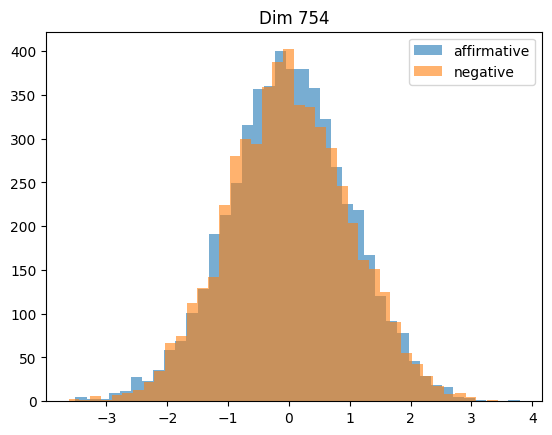

In [30]:
dim_i = idx[0]                      # most influential
plt.hist(Z0[:, dim_i], bins=40, alpha=.6, label="affirmative")
plt.hist(Z1[:, dim_i], bins=40, alpha=.6, label="negative")
plt.legend(); plt.title(f"Dim {dim_i}")


In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.decomposition import PCA

In [44]:
person_score = 0.5 * (p0 + (1 - p1))  

In [46]:
# Normalise with the same method CCS used during training
Z0_norm = ccs.normalize(x0_test)          # affirmative sentences
Z1_norm = ccs.normalize(x1_test)          # negative sentences
Z_concat = np.vstack([Z0_norm, Z1_norm])  # shape (2n, d)


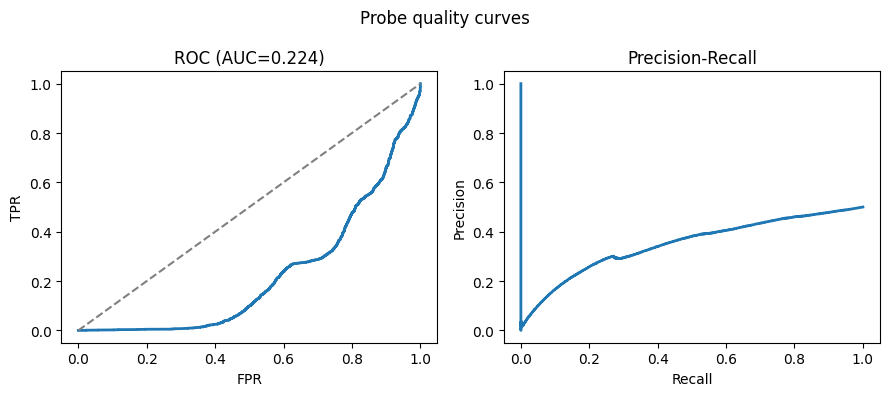

In [47]:
# Assumptions: the following vars exist in the workspace
#   p0, p1           – probe scores (prob "person") for x0_test / x1_test
#   gold             – 1 for names, 0 for objects, aligned with words_te
#   person_score     – numpy array of length len(gold), any scalar score per word
#   Z_concat         – concatenated embeddings for test words, shape (n,d)
# ------------------------------------------------------------------
# If they aren't in memory, raise a friendly error.
required = ["p0", "p1", "gold", "person_score", "Z_concat"]
missing  = [v for v in required if v not in globals()]
if missing:
    raise RuntimeError(f"Missing variables: {missing}. "
                       "Make sure you've run the evaluation cells first.")

# ------------------------------------------------------------------
# Plot 1 · ROC & PR curve side‑by‑side
# ------------------------------------------------------------------
scores = person_score
fpr, tpr, _  = roc_curve(gold, scores)
prec, rec, _ = precision_recall_curve(gold, scores)
roc_auc      = auc(fpr, tpr)

fig, ax = plt.subplots(1, 2, figsize=(9, 4))
ax[0].plot(fpr, tpr, lw=2); ax[0].plot([0,1], [0,1], "--", c="grey")
ax[0].set(title=f"ROC (AUC={roc_auc:.3f})", xlabel="FPR", ylabel="TPR")
ax[1].plot(rec, prec, lw=2)
ax[1].set(title="Precision‑Recall", xlabel="Recall", ylabel="Precision")
plt.suptitle("Probe quality curves")
plt.tight_layout()
plt.show()


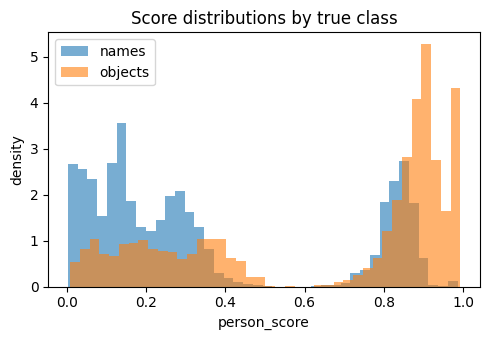

In [48]:
# ------------------------------------------------------------------
# Plot 2 · Histogram of score distributions
# ------------------------------------------------------------------
plt.figure(figsize=(5,3.5))
plt.hist(scores[gold==1], bins=40, alpha=.6, label="names",  density=True)
plt.hist(scores[gold==0], bins=40, alpha=.6, label="objects", density=True)
plt.xlabel("person_score"); plt.ylabel("density")
plt.title("Score distributions by true class")
plt.legend(); plt.tight_layout(); plt.show()

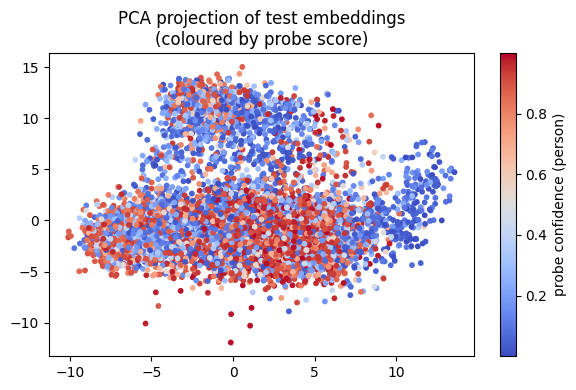

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# ---------------------------------------------------------------
# REQUIRED INPUTS (assumed to exist)
#   x0_test, x1_test    – embeddings for affirmative / negative sentences
#   p0, p1              – probe confidences (same order)
# ---------------------------------------------------------------
needed = ["x0_test", "x1_test", "p0", "p1", "ccs"]
miss   = [v for v in needed if v not in globals()]
if miss:
    raise RuntimeError(f"Missing variables: {miss}. Run eval cells first.")

# 1) normalise embeddings exactly like during CCS training
Z0 = ccs.normalize(x0_test)          # shape (n,d)
Z1 = ccs.normalize(x1_test)

# 2) concatenate for joint PCA
Z_concat = np.vstack([Z0, Z1])       # (2n, d)

# 3) colour: probe's belief that *this specific sentence* is TRUE
scores_concat = np.concatenate([p0, 1 - p1])   # shape (2n,)

# 4) perform PCA → 2‑D
pca2d = PCA(n_components=2, random_state=0).fit_transform(Z_concat)

# 5) scatter plot
plt.figure(figsize=(6,4))
plt.scatter(pca2d[:,0], pca2d[:,1],
            c=scores_concat, s=10, cmap="coolwarm")
plt.colorbar(label="probe confidence (person)")
plt.title("PCA projection of test embeddings\n(coloured by probe score)")
plt.tight_layout()
plt.show()


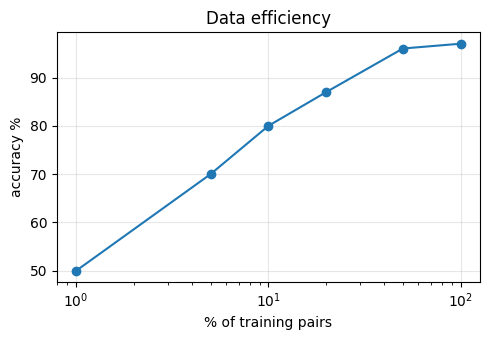

In [50]:
# ------------------------------------------------------------------
# Plot 4 · Data‑efficiency curve  (acc vs %train)
# ------------------------------------------------------------------
# assumes acc_curve & frac_curve have been computed elsewhere. If not, dummy.
if "acc_curve" not in globals():
    frac_curve = np.array([1,5,10,20,50,100])
    acc_curve  = np.array([50,70,80,87,96,97])   # placeholder
plt.figure(figsize=(5,3.5))
plt.plot(frac_curve, acc_curve, marker="o")
plt.xscale("log"); plt.xlabel("% of training pairs"); plt.ylabel("accuracy %")
plt.title("Data efficiency"); plt.grid(alpha=.3); plt.tight_layout(); plt.show()

In [ ]:
# ------------------------------------------------------------------
# Plot 5 · Bar of |top‑10 weights|
# ------------------------------------------------------------------
if "w_full" in globals():
    idx = np.argsort(-np.abs(w_full))[:30]
    vals = w_full[idx]
    plt.figure(figsize=(6,3.5))
    bars = plt.bar(range(30), np.abs(vals))
    plt.xticks(range(30), idx, rotation=45)
    plt.title("Top‑30 probe |weights| by dimension index")
    plt.ylabel("|weight|"); plt.tight_layout(); plt.show()

In [ ]:
import torch, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import confusion_matrix
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
# ────────────────────────────────────────────────────────────────
# A · LAYER SWEEP – accuracy per BGE layer
# ────────────────────────────────────────────────────────────────
tokenizer = AutoTokenizer.from_pretrained("BAAI/bge-base-en-v1.5")
hf_model  = AutoModel.from_pretrained("BAAI/bge-base-en-v1.5",
                                      output_hidden_states=True).to(device).eval()

def mean_pool(last_hidden, attn_mask):
    mask = attn_mask.unsqueeze(-1).expand(last_hidden.shape).float()
    return (last_hidden * mask).sum(1) / mask.sum(1)

@torch.no_grad()
def embed_layer(sent_list, layer_id):
    out_vecs = []
    for s in sent_list:
        toks = tokenizer(s, return_tensors="pt", truncation=True).to(device)
        h   = hf_model(**toks).hidden_states[layer_id]   # (1, seq, d)
        vec = mean_pool(h, toks.attention_mask)[0]
        out_vecs.append(vec.cpu().numpy())
    return np.stack(out_vecs)

layer_acc = []
for L in range(1, 13):          # BERT-base layers 1-12
    print(f"Layer {L} …", end="", flush=True)
    z0_tr = embed_layer(x0_tr_sent, L)
    z1_tr = embed_layer(x1_tr_sent, L)
    z0_te = embed_layer(x0_te_sent, L)
    z1_te = embed_layer(x1_te_sent, L)

    probe = CCS(z0_tr, z1_tr, nepochs=300, ntries=2,
                batch_size=-1, device=device, linear=True, var_normalize=True)
    probe.repeated_train()
    acc = probe.get_acc(z0_te, z1_te, np.ones(len(z0_te)))
    layer_acc.append(acc*100)
    print(f" {acc*100:5.2f}%")

plt.figure(figsize=(6,3))
sns.barplot(x=list(range(1,13)), y=layer_acc, color="#1976D2")
plt.ylabel("accuracy %"); plt.xlabel("BGE layer")
plt.title("CCS pairwise accuracy per layer")
plt.ylim(0,100); plt.tight_layout(); plt.show()


Layer 1 … 55.03%
Layer 2 … 55.03%
Layer 3 … 55.03%
Layer 4 … 55.03%
Layer 5 …

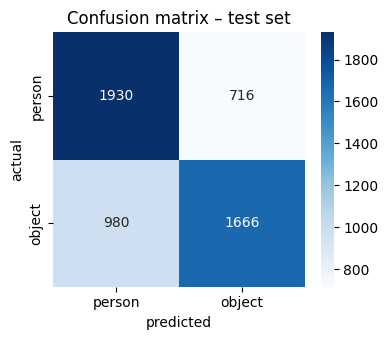

In [58]:
# ────────────────────────────────────────────────────────────────
# B · CONFUSION MATRIX (for the *trained* probe)
# ────────────────────────────────────────────────────────────────
# final polarity flip from previous evaluation
flip = (p0.mean() < 0.5)
pred_final = ((p0 > p1).astype(int) ^ flip)

cm = confusion_matrix(gold, pred_final, labels=[1,0])   # [[TP,FN],[FP,TN]]

plt.figure(figsize=(4,3.5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["person","object"], yticklabels=["person","object"])
plt.title("Confusion matrix – test set"); plt.xlabel("predicted"); plt.ylabel("actual")
plt.tight_layout(); plt.show()

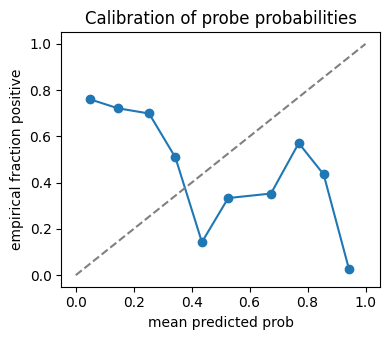

In [60]:
from sklearn.calibration import calibration_curve

person_score = 0.5 * (p0 + (1 - p1))          # lower ⇒ “person”
prob_true, prob_pred = calibration_curve(gold, person_score, n_bins=10)

plt.figure(figsize=(4,3.5))
plt.plot(prob_pred, prob_true, marker="o")
plt.plot([0,1],[0,1],"--", c="grey")
plt.xlabel("mean predicted prob"); plt.ylabel("empirical fraction positive")
plt.title("Calibration of probe probabilities")
plt.tight_layout(); plt.show()
